## Домашнее задание к лекции 4.3 «Работа с данными»
Решение выполнения задач необходимо предоставить в виде ссылки на файл формата Jupyter (ipynb) в GitHub.

В файле должны быть сохранены результаты запуска на тестовых данных.

Дано: API для данных о футбольных матчах и командах.

Используя kmeans сделать кластеризацию футбольных команд по стоимости и количеству проигрышей, результат отобразить в виде точечного графика для случая из 3 и из 5 кластеров.

### Подключаем API
Для примера используем открытое API, которое предоставляет данные о футбольных командах и матчах.

http://api.football-data.org/docs/v1/index.html

Для полноценного использования лучше всего получить ключ, это довольно просто.

http://api.football-data.org/client/register

In [77]:
import requests
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.cluster.vq import whiten, kmeans2

In [3]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': '60af729360a84f92a143687f89097d33' }).json()
        return json[result_key]
    except:
        print(json)
        return None

In [67]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/448/teams', 'teams')
teams[0]

{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/1145/fixtures'},
  'players': {'href': 'http://api.football-data.org/v1/teams/1145/players'},
  'self': {'href': 'http://api.football-data.org/v1/teams/1145'}},
 'code': None,
 'crestUrl': None,
 'name': 'Accrington Stanley',
 'shortName': None,
 'squadMarketValue': None}

In [78]:
# Для каждой команды получаем игроков и игры.

for team in teams:
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    lose_games = 0
    market_value = 0
    for f in fixtures:
        if f['homeTeamName'] == team['name']:
            goals_our = f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
            goals_enemy = f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
        else:
            goals_our = f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
            goals_enemy = f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        lose_games += 1 if goals_our < goals_enemy else 0
    market_value += team['squadMarketValue'] if team['squadMarketValue'] else 0
    market_value = market_value if market_value else 90000 * random.random()
    print('Team "{}", {} lose games, {} market value'.format(team['name'], lose_games, market_value))
    team['lose_games'] = lose_games
    team['market_value'] = market_value

Team "Accrington Stanley", 8 lose games, 41971.658832728965 market value
Team "Colchester United FC", 9 lose games, 39655.01104848991 market value
Team "Stevenage FC", 11 lose games, 13350.425808417034 market value
Team "Newport County", 7 lose games, 47048.54780943671 market value
Team "Morecambe FC", 12 lose games, 36097.335371953464 market value
Team "Cheltenham Town", 12 lose games, 86116.63491176307 market value
Team "Luton Town", 5 lose games, 16923.7568752487 market value
Team "Yeovil Town", 13 lose games, 25807.832450395566 market value
Team "Forest Green Rovers", 16 lose games, 55817.04263089096 market value
Team "Barnet FC", 17 lose games, 23147.774427083143 market value
Team "Exeter City", 9 lose games, 68501.66373572193 market value
Team "Cambridge United", 9 lose games, 9901.928518709665 market value
Team "Crewe Alexandra FC", 16 lose games, 78856.75697554092 market value
Team "Mansfield Town", 5 lose games, 75292.79719150868 market value
Team "Crawley Town", 11 lose games

In [79]:
# Готовим данные для трансформации в Pandas

team_for_pd = []
for team in teams:
    if team['market_value']:
        team_for_pd.append({'name': team['name'], 'lose_games': team['lose_games'], 'market_value': team['market_value']})
    
team_for_pd

[{'lose_games': 8,
  'market_value': 41971.658832728965,
  'name': 'Accrington Stanley'},
 {'lose_games': 9,
  'market_value': 39655.01104848991,
  'name': 'Colchester United FC'},
 {'lose_games': 11,
  'market_value': 13350.425808417034,
  'name': 'Stevenage FC'},
 {'lose_games': 7,
  'market_value': 47048.54780943671,
  'name': 'Newport County'},
 {'lose_games': 12,
  'market_value': 36097.335371953464,
  'name': 'Morecambe FC'},
 {'lose_games': 12,
  'market_value': 86116.63491176307,
  'name': 'Cheltenham Town'},
 {'lose_games': 5, 'market_value': 16923.7568752487, 'name': 'Luton Town'},
 {'lose_games': 13, 'market_value': 25807.832450395566, 'name': 'Yeovil Town'},
 {'lose_games': 16,
  'market_value': 55817.04263089096,
  'name': 'Forest Green Rovers'},
 {'lose_games': 17, 'market_value': 23147.774427083143, 'name': 'Barnet FC'},
 {'lose_games': 9, 'market_value': 68501.66373572193, 'name': 'Exeter City'},
 {'lose_games': 9,
  'market_value': 9901.928518709665,
  'name': 'Cambrid

In [80]:
# Трансформируем

teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,lose_games,market_value,name
0,8,41971.658833,Accrington Stanley
1,9,39655.011048,Colchester United FC
2,11,13350.425808,Stevenage FC
3,7,47048.547809,Newport County
4,12,36097.335372,Morecambe FC
5,12,86116.634912,Cheltenham Town
6,5,16923.756875,Luton Town
7,13,25807.832450,Yeovil Town
8,16,55817.042631,Forest Green Rovers
9,17,23147.774427,Barnet FC


In [81]:
# Удаляем колонку с именами

del teams_pd['name']
teams_pd

,lose_games,market_value
0,8,41971.658833
1,9,39655.011048
2,11,13350.425808
3,7,47048.547809
4,12,36097.335372
5,12,86116.634912
6,5,16923.756875
7,13,25807.832450
8,16,55817.042631
9,17,23147.774427


In [82]:
# Нормализация данных

whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 2.21304513,  1.67266614],
       [ 2.48967577,  1.58034246],
       [ 3.04293706,  0.53204486],
       [ 1.93641449,  1.87499173],
       [ 3.3195677 ,  1.43856098],
       [ 3.3195677 ,  3.43194393],
       [ 1.38315321,  0.67445023],
       [ 3.59619834,  1.02850087],
       [ 4.42609026,  2.2244362 ],
       [ 4.7027209 ,  0.9224915 ],
       [ 2.48967577,  2.72994723],
       [ 2.48967577,  0.39461439],
       [ 4.42609026,  3.14262127],
       [ 1.38315321,  3.00058936],
       [ 3.04293706,  2.88275068],
       [ 3.87282898,  2.63419437],
       [ 2.48967577,  1.19808506],
       [ 1.10652257,  0.50041807],
       [ 4.42609026,  2.80257785],
       [ 3.3195677 ,  0.76044017],
       [ 2.76630641,  2.88404947],
       [ 2.76630641,  0.6687041 ],
       [ 1.93641449,  1.33510896],
       [ 1.93641449,  3.19994212]])

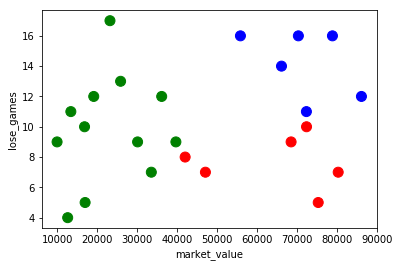

In [84]:
# Сделаем 3 кластера

centroids, cluster_map = kmeans2(whitened, 3)

# Зададим цвета для каждого кластера

colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

# Выведем кластеры

teams_pd.plot.scatter(x='market_value', y='lose_games', c=colors, s=100)

C:\Users\hp\Anaconda3\lib\site-packages\scipy\cluster\vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


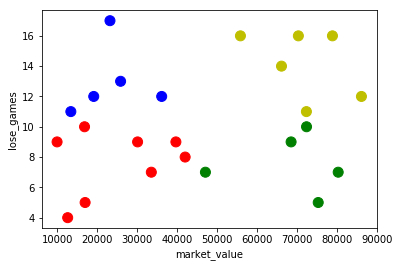

In [85]:
# Сделаем 5 кластеров

centroids, cluster_map = kmeans2(whitened, 5)

# Зададим цвета для каждого кластера

colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

# Выведем кластеры

teams_pd.plot.scatter(x='market_value', y='lose_games', c=colors, s=100)